<a href="https://colab.research.google.com/github/erika-munho/TalentoTech/blob/main/Copia_de_Data_Analysis_using_SQL_LIGAS_FOOTBALL_EUROPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F63%2F589%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T020402Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dacebec79ed71169eb44fd78ba5e5fbae438e456369bc4a578e703b6232e08e5634c161f6fa564a97196ab4ca4883c87b44fdfb145814dc3638f7bcad1337e7c0ad69db2bbd9217a03a3eba4933ed8490ec23c94fad9a41bb957b9e5aade977bb97665bd40d07f259990e8af4a2e4e83eedab6f9bef3dc034a8d25d2339798fcfc5cdc846d3ee18b6a0bc71cad3a81539bdabf6b126598d5e2cd61b092305fefb05a80fee4379d7685d90173f8074050a2bcdaea4fd80c1504075ac9b05d8f24c59fa288127efd7b45969d4890f8a8e58e7ccc95341f7ec59eb1242d1ac7b6cb919d5b626a83e917ec3bece6faa6fd2b65e41fe2f81a80fe86cf91296ccba3b17'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34297253 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# Motivation
I'll use this script to provide introduction to data analysis using SQL language, which should be a must tool for every data scientist - both for getting access to data, but more interesting, as a simple tool for advance data analysis.
The logic behind SQL is very similar to any other tool or language that used for data analysis (excel, Pandas),  and for those that used to work with data, should be very intuitive.

# Important Definitions
SQL is a conceptual language for working with data stored in databases. In our case, SQLite is the specific implementation. Most SQL languges share all of the capabilities in this doc. The differences are usually in performance and advances analytical funcionalities (and pricing of course).
Eventually, we will use SQL lunguage to write queries that would pull data from the DB, manipulate it, sort it, and extract it.

The most important component of the DB  is its tables - that's where all the data stored. Usually the data would be devided to many tables, and not stored all in one place (so designing the data stracture properly is very important). Most of this script would handle how to work with tables.
Other than tables, there are some other very useful concepts/features that we won't cover here:
* table creation
* inserting / updating data in the DB
* functions - gets a value as an input, and returns manipulation of that value (for example function that remove white spaces)

In [2]:
#Improts

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "../input/"  #Insert path here
database = path + 'database.sqlite'

# First we will create the connection to the DB, and see what tables we have
The basic structure of the query is very simple:
You define what you want to see after the SELECT, * means all possible columns
You choose the table after the FROM
You add the conditions for the data you want to use from the table(s) after the WHERE

The stracture, and the order of the sections matter, while spaces, new lines, capital words and indentation are there to make the code easier to read.

In [3]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


# **COMENTARIO:**
Esta primera tabla presenta el total de tablas que contiene la base de datos, en total son ocho, identifica además el nombre de cada una, la rootpage o página raíz, que indica la página desde la cual se inicia la búsqueda en la base de datos, y facilita la recuperación de los mismos.   entre las que se incluye. Finalmente incluye el comando para la creción de cada table en leguaje sql.

# List of countries
This is the most basic query.
The only must parts of a qeury is the SELECT and the FROM (assuming you want to pull from a table)

In [4]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


# **COMENTARIO:**
Esta tabla muestra el nombre y la identificación de los 11 paises de Europa que cuentan con las ligas de football mas destacadas del continente europeo.

# List of Leagues

In [14]:
query = """SELECT * FROM League;"""

countries = pd.read_sql(query, conn)

countries

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


# List of leagues and their country
JOIN is used when you want to connect two tables to each other. It works when you have a common key in each of them.
Understanding the concept of Keys is crucial for connecting (joining) between data set (tables).
A key is uniquely identifies each record (row) in a table.
It can consinst of one value (cell) - usually ID, or from a combination of values that are unique in the table.

When joinin between different tables, you must:
* Decide what type of join to use. The most common are:
* * (INNER) JOIN - keep only records that match the condition (after the ON) in both the tables, and records in both tables that do not match wouldn't appear in the output
* * LEFT JOIN - keep all the values from the first (left) table - in conjunction with the matching rows from the right table. The columns from the right table, that don't have matching value in the left, would have NULL values.
* Specify the common value that is used to connect the tables (the ID of the country in that case).
* Make sure that at least one of the values has to be a key in its table. In our case, it's the Country.id. The League.country_id is not unique, as there can be more than one league in the same country

JOINs, and using them incorrectly, is the most common and dangerious mistake when writing complicated queries

In [5]:
leagues = pd.read_sql("""SELECT *
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", conn)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


# **COMENTARIO:**
Aquí se presenta el nombre de cada una de las ligas con su respectiva identificacón para cada uno de los once países, se incluyen ligas muy reconocidas como la Premier League de Inglaterra, la Busdesliga alemana, liga BBVA de España, la Serie A de Italia y la France League, entre otras.

# List of teams
ORDER BY defines the sorting of the output - ascending or descending (DESC)

LIMIT, limits the number of rows in the output - after the sorting

In [6]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name
                        LIMIT 10;""", conn)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


# **COMENTARIO:**
Esta tabla muestra una lista organizada según el nombre completo de los equipos de las diferentes liga de europa, presentando los 10 primeros resultados de acuardo al orden alfbético de los nombres.

# List of matches
In this exapmle we will show only the columns that interests us, so instead of * we will use the exact names.

Some of the cells have the same name (Country.name,League.name). We will rename them using AS.

As you can see, this query has much more joins. The reasons is because the DB is designed in a star
structure - one table (Match) with all the "performance" and metrics, but only keys and IDs,
while all the descriptive information stored in other tables (Country, League, Team)

Note that Team is joined twice. This is a tricky one, as while we are using the same table name, we basically bring two different copies (and rename them using AS). The reason is that we need to bring information about two different values (home_team_api_id, away_team_api_id), and if we join them to the same table, it would mean that they are equal to each other.

You will also note that the Team tables are joined using left join. The reason is that I would prefer to keep the matches in the output - even if one of the teams is missing from the Team table for some reason.

ORDER defines the order of the output, and comes before the LIMIT and after the WHERE

In [7]:
detailed_matches = pd.read_sql("""SELECT Match.id,
                                        Country.name AS country_name,
                                        League.name AS league_name,
                                        season,
                                        stage,
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal,
                                        away_team_goal
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER by date
                                LIMIT 10;""", conn)
detailed_matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0
5,21522,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Racing Santander,Sevilla FC,1,1
6,21523,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Sporting de Gijón,Getafe CF,1,2
7,21524,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Betis Balompié,RC Recreativo,0,1
8,21526,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Athletic Club de Bilbao,UD Almería,1,3
9,21527,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Atlético Madrid,Málaga CF,4,0


# **COMENTARIO:**
Esta tabla muestra los 10 resutados encontrados para la liga BBVA de España, que incluye la temporada, la fecha del partido, el nombre el del equipo local,  nombre del equipo visitante, y resultado del partido expresado en el  número de goles del equipo local, y goles del equipo visitante. La información presentada está ordenada de acuerdo a la fecha.

# Let's do some basic analytics
Here we are starting to look at the data at more aggregated level. Instead of looking on the raw data we will start to grouping it to different levels we want to examine.
In this example, we will base it on the previous query, remove the match and date information, and look at it at the country-league-season level.

The functionality we will use for that is GROUP BY, that comes between the WHERE and ORDER

Once you chose what level you want to analyse, we can devide the SELECT statement to two:
* Dimensions - those are the values we describing, same that we will group by later.
* Metrics - all the metrics have to be aggregated using functions.
The common functions are: sum(), count(), count(distinct ...), avg(), min(), max()

Note - it is very important to use the same dimensions both in the SELECT, and in the GROUP BY. Otherwise the output might be wrong.

Another functionality that can be used after grouping, is HAVING. This adds another layer of filtering the data, this time the output of the table **after** the grouping. A lot of times it is used to clean the output.


In [8]:
leages_by_season = pd.read_sql("""SELECT Country.name AS country_name,
                                        League.name AS league_name,
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors,
                                        avg(away_team_goal) AS avg_away_team_goals,
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif,
                                        avg(home_team_goal+away_team_goal) AS avg_goals,
                                        sum(home_team_goal+away_team_goal) AS total_goals
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY Country.name, League.name, season DESC
                                ;""", conn)
leages_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


# **COMENTARIO:**
Esta tabla presenta información de cinco ligas europeas, ordenadas por países  estos son Inglaterra, Alemania, Francia, Italia y España, los datos para cada país están organizados por temporadas en orden desendentes,que incluyen ocho temporadas inicando en 2015/2016 y terminando en 2008/2009.

entre los datos que se presentan para cada una de las ligas en las ocho temporadas se destaca el número de equipos, todas cuentan con 20 a excepción de  la Bundesliga alemana, que tiene 18. Tambien está el promedio de goles marcados por los equipos como visitantes y como locales, el promedio de gol diferencia, el promedio de gol marcado y los goles totales marcados para cada temporada.

# Filtrado de Tablas

In [15]:
leages_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['number_of_stages'].plot(kind='hist', bins=20, title='number_of_stages')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['number_of_teams'].plot(kind='hist', bins=20, title='number_of_teams')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['avg_home_team_scors'].plot(kind='hist', bins=20, title='avg_home_team_scors')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('country_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('league_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('season').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='number_of_stages', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='number_of_stages', y='number_of_teams', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='number_of_teams', y='avg_home_team_scors', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='avg_home_team_scors', y='avg_away_team_goals', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['number_of_stages']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('country_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='country_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('number_of_stages')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['number_of_stages']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('league_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='league_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('number_of_stages')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['number_of_stages']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('season')):
  _plot_series(series, series_name, i)
  fig.legend(title='season', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('number_of_stages')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['number_of_teams']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('country_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='country_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('number_of_teams')

from matplotlib import pyplot as plt
_df_15['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['number_of_stages'].plot(kind='line', figsize=(8, 4), title='number_of_stages')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['number_of_teams'].plot(kind='line', figsize=(8, 4), title='number_of_teams')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['avg_home_team_scors'].plot(kind='line', figsize=(8, 4), title='avg_home_team_scors')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['league_name'].value_counts()
    for x_label, grp in _df_19.groupby('country_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('country_name')
_ = plt.ylabel('league_name')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['season'].value_counts()
    for x_label, grp in _df_20.groupby('league_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('league_name')
_ = plt.ylabel('season')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['country_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='index', y='country_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['league_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='index', y='league_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['season'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='index', y='season', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['country_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='number_of_stages', y='country_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# **COMENTARIO:**

La tabla anterior permite obtener, gracias al filtrado por promedio de goles marcados como local y promedio de goles marcados como visitante, teniendo en cuenta que se ingresa el número mas alto para goles local y el registro más bajo para gol como visitante, ésto con el propósito de obtener información de las ligas mas competitivas en términos de juego ofensivo, pero a la vez capacidad de defensa, ésto para todas las temporadas, obteniendo como resultado que la liga mas competitiva se localiza en España, seguida muy de lejos por la Premier Liague y la Bundesliga. Se puede concluir tambien que este nivel de rendimiento permite obtener un importante número de anotaciones evidenciado en los goles totales.

<Axes: title={'center': 'Average Goals per Game Over Time'}>

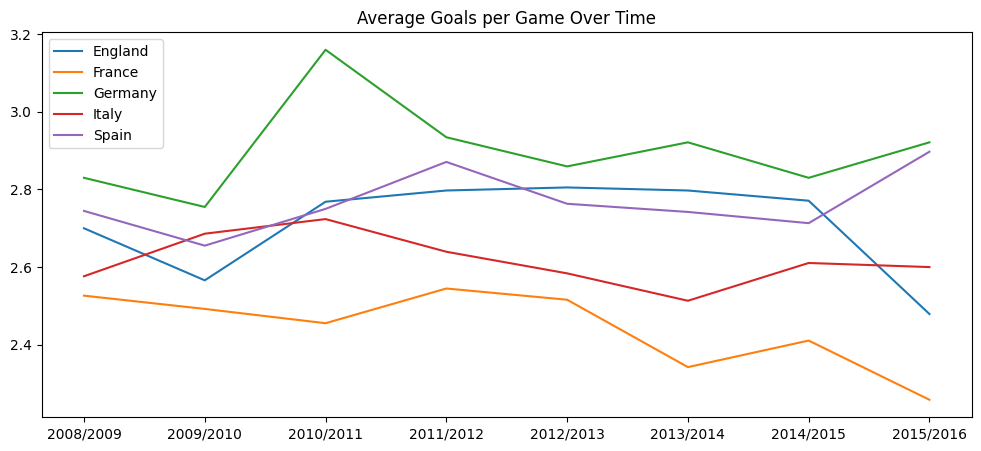

In [9]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time')

# **ANALISIS**
La gráfica anterior, que representa el promedio de goles por partido entre las temporadas de 2008 a 2016, la Bundesliga de Alemania presenta una promedio superior a las demás para todas las temporadas, el cual está por encima de los 2.8 goles, sobresaliendo la temporada 2010/2011 con un promedio cercano al 3.2. La liga con el menor promedio durante todas las temporadas es Francia, la cual siempre se ha mostrado siempre por debajo de las otras ligas europeas, con goles promedio por debajo de 2.6, cabe destacar el 2011 su promedio de goles viene en descenso, alcanzando para última temporada 2015/2016 0.31.
Finalmente el gol promedio para las ligas de España, Inglaterra e Italia se encuentra oscilando entre un poco menos de 2.6 y un valor ligeramente superior a 2.8.

<Axes: title={'center': 'Average Goals Difference Home vs Out'}>

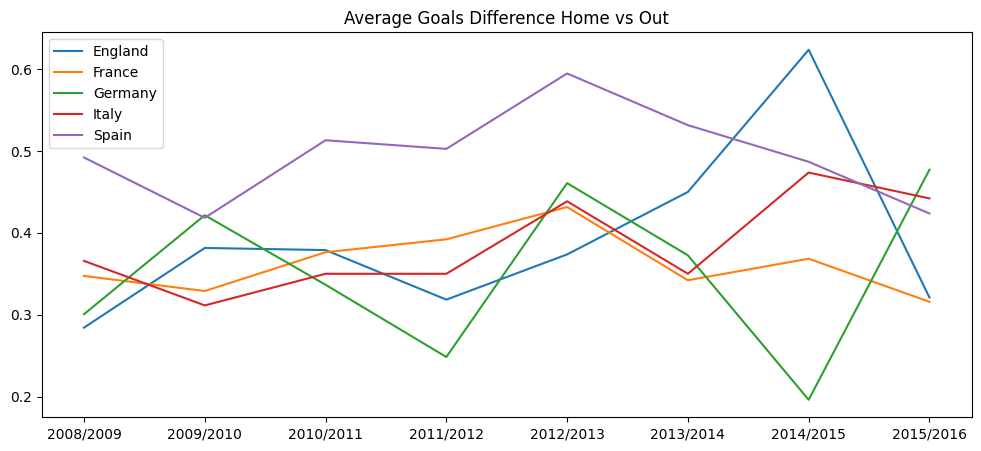

In [10]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])

df.plot(figsize=(12,5),title='Average Goals Difference Home vs Out')

# **ANALISIS**
En cuanto al gol diferencia, se puede observar en la gráfica que para el caso de la liga Española el gol diferencia está por encima de 0.4 y por debajo de 0.6, ubicándola como la liga con mayor número de goles diferencia, durante todas las temporadas, a excepción de la temporada 2014-2016, esto indica que es una liga altamente competitiva donde los equipos tienden a marcar más goles de los que reciben, que sugiere un juego más ofensivo o una defensa más sólida
Francia e Italia son las ligas que mantiene un gol diferencia relativamente estable durante las temporadas que se analizan, 2008 a 2016, ya que el promedio de gol diferencia se ubica entre 0.3 y 0.4 goles a favor en comparación a los que conceden por partido, lo que demuestra un rendimiento positivo en términos de anotaciones. Este comportamiento se observa también para la liga inglesa con excepción de la temporada 2014/2015, donde el promedio del gol diferencia alcanza el 0.6, lo cual indica un notable incremento en el número de goles marcados a favor, por tanto un cambio en la estrategia táctica de juego hacia una liga mucho más ofensiva.
Finalmente la Bundesliga alemana presenta un comportamiento muy irregular en términos de gol diferencia, con ascensos y descensos notables a lo largo de todas las temporadas, con diferencia de goles promedio oscilando entre 0.2 y 0.5, que demuestra cambios importantes en la eficiencia tanto ofensiva como defensiva de los equipos, que puede obedecer a cambios notables en las nóminas, estrategias de juego, dirección técnica entro otros.

# Query Run Order
Now that we are familiar with most of the functionalities being used in a query, it is very important to understand the order that code runs.

As we mentioned, here is the order as it would appear in the code:
* SELECT
* FROM
* JOIN
* WHERE
* GROUP BY
* HAVING
* ORDER BY
* LIMIT

You can think of it as a two part process:
First, create a new temporal table in the memory:
* Define which tables to use, and connect them (FROM + JOIN)
* Keep only the rows that apply to the conditions (WHERE)
* Group the data by the required level (if need) (GROUP BY)
* Choose what information you want to have in the new table. It can have just rawdata (if no grouping), or combination of dimensions (from the grouping), and metrics
Then, choose what to show from the table:
* Order the output of the new table (ORDER BY)
* Add more conditions that would filter the new created table (HAVING)
* Limit to number of rows - would cut it according the soring and the having filtering (LIMIT)


# Sub Queries and Functions

Using subqueries is an essential tool in SQL, as it allows manipulating the data in very advanced ways without the need of any external scripts, and especially important when your tables stractured in such a way that you can't be joined directly.

In our example, I'm trying to join between a table that holds players' basic details (name, height, weight), to a table that holds more attributes. The problem is that while the first table holds one row for each player, the key in the second table is player+season, so if we do a regular join, the result would be a cartesian product, and each player's basic details would appear as many times as this player appears in the attributes table. The result would be that the average would be skewed towards players that appear many times in the attribute table.

The solution, is to use a subquery.  We would need to group the attributes table, to a different key - player level only (without season). Of course we would need to decide first how we would want to combine all the attributes to a single row. I used average, but one can also decide on maximum, latest season and etc.
Once both tables have the same keys, we can join them together (think of the subquery as any other table, only temporal), knowing that we won't have duplicated rows after the join.

In addition, you can see here two examples of how to use functions:
* Conditional function is an important tool for data manipulation. While IF statement is very popular in other languages, SQLite is not supporting it, and it's implemented using CASE + WHEN + ELSE statement.
As you can see, based on the input of the data, the query would return different results.

* ROUND - straight sorward.
Every SQL languages comes with a lot of usefull functions by default.

In [11]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height,
                                        COUNT(height) AS distribution,
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id,
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential
                                        FROM Player_Attributes
                                        GROUP BY Player_Attributes.player_api_id)
                                        AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", conn)
players_height

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


# **ANALISIS**

La tabla anterior se realiza empleando subqueries o subconsultas, que resultan bastante útiles para manipular datos de formas muy avanzadas sin necesidad de ningún script externo, y especialmente importante cuando sus tablas están estructuradas de tal forma que no se pueden unir directamente. En este caso se está intentando unir una tabla que contiene los datos básicos de los jugadores (nombre, altura, peso) con otra tabla que contiene mas atributos, cuya clave es jugador + temporadas, por tanto no están relacionadas con ninguna clave; la subconsult permite entonces agrupar la tabla de atributos con una clave diferente, sólo nivel del jugador sin temporada y es necesario agrupar todos los atributos en una sola fila utilizando la media por ejemplo.
De esta manera se obtiene esta tabla que presenta información relacionada con la altura de los jugadores compredida entre 165 y 195 cms, una distribución del valor de las alturas, un promedio de clasificación general, un potencial promedio y el peso promedio, todos los datos se ordenan de acuerdo a la altura.



<Axes: title={'center': 'Potential vs Height'}, xlabel='calc_height'>

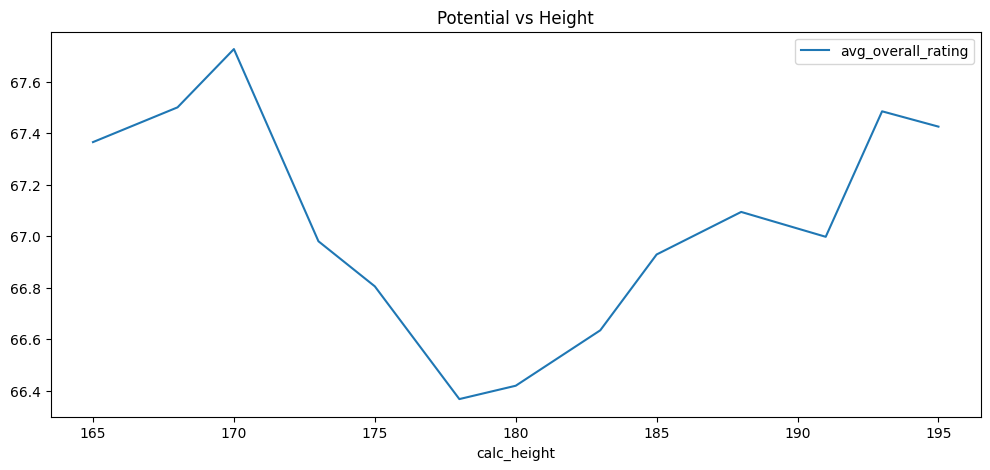

In [13]:
players_height.plot(x=('calc_height'),y=('avg_overall_rating'),figsize=(12,5),title='Potential vs Height')

# **ANALISIS**
Con la ayuda la IA se puede resumir la gráfica de la siguiiente manera:
La gráfica presenta la relación entre dos variables, en este caso la altura calculada de los jugadores en el eje "x" y potencial del rendimiento prommedio general en el eje "y".
La línea muestra la tendencia de cómo el potencial promedio general de los jugadores cambia a medida que su altura calculada aumenta o disminuye.
La gráfica muestra una correlación positiva de los datos cuando la dirección de la línea es ascendente, esto es que el pontencial tiende a subir cuando la altura de los jugadores aumenta, esto ocurre en intervalos de altura que se registran entre 165 a 170 y de otra parte entra 178 y 194 aproximadamente.
Sin embargo se presenta una correlación negativa, evidenciada por la dirección descendente de la línea, por tanto una disminución del potencial a medida que la altura aumenta, cuando ésta oscila entre 170 y 178.
Se puede concluir que la correlación o relación entre potencial y altura no es lineal, evidenciando una relación compleja entre estas variables, que pueden estar asociadas a otros factores de importancia a considerar, como la posición del jugador, la habilidad técnica y la experiencia, entre otros.
